In [1]:
from itertools import islice

import matplotlib.dates as mdates
import pandas as pd
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from matplotlib import pyplot as plt

from tqdm.autonotebook import tqdm
import yfinance as yf

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/tmp/ipykernel_858950/1806486080.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location="cuda:0") # Uses GPU since in this Colab we use a GPU.
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    print(estimator.lags_seq)

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

/tmp/ipykernel_858950/3902027965.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location="cuda:0") # Uses GPU 

In [23]:
dataset = get_dataset('hospital')

data_test = dataset.test
data_train = dataset.train
prediction_length = 20
context_length = 75
device = torch.device('cuda:0')

In [24]:
print(len(next(iter(data_train))['target'])) #182
print(len(next(iter(data_test))['target'])) #212
print(len(data_train))

72
84
767


In [25]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location="cuda:0")
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=0.0001,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },
        # use_cosine_annealing_lr=True,
        # cosine_annealing_lr_args={
        #     'T_max':50,
        #     'eta_min':1e-6
        # },
        batch_size=64,
        num_parallel_samples=100,
        trainer_kwargs = {
            "max_epochs": 50,
        }, # <- lightning trainer arguments
    )

predictor = estimator.train(
    data_train,
    cache_data=True,
    shuffle_buffer_length=1000
)

/tmp/ipykernel_858950/1483173086.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location="cuda:0")
/home/abiza

Epoch 0: |          | 50/? [00:02<00:00, 19.79it/s, v_num=12]

Epoch 0, global step 50: 'train_loss' reached 3.91870 (best 3.91870), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:02<00:00, 19.30it/s, v_num=12]

Epoch 1, global step 100: 'train_loss' reached 3.83837 (best 3.83837), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:02<00:00, 19.34it/s, v_num=12]

Epoch 2, global step 150: 'train_loss' reached 3.83584 (best 3.83584), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:02<00:00, 19.31it/s, v_num=12]

Epoch 3, global step 200: 'train_loss' reached 3.79460 (best 3.79460), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:02<00:00, 19.29it/s, v_num=12]

Epoch 4, global step 250: 'train_loss' was not in top 1


Epoch 5: |          | 50/? [00:02<00:00, 19.36it/s, v_num=12]

Epoch 5, global step 300: 'train_loss' reached 3.79151 (best 3.79151), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:02<00:00, 19.25it/s, v_num=12]

Epoch 6, global step 350: 'train_loss' reached 3.75806 (best 3.75806), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:02<00:00, 19.31it/s, v_num=12]

Epoch 7, global step 400: 'train_loss' reached 3.74754 (best 3.74754), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:02<00:00, 19.33it/s, v_num=12]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:02<00:00, 19.17it/s, v_num=12]

Epoch 9, global step 500: 'train_loss' reached 3.73679 (best 3.73679), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:02<00:00, 19.29it/s, v_num=12]

Epoch 10, global step 550: 'train_loss' reached 3.72938 (best 3.72938), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:02<00:00, 19.19it/s, v_num=12]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:02<00:00, 19.23it/s, v_num=12]

Epoch 12, global step 650: 'train_loss' reached 3.72612 (best 3.72612), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:02<00:00, 19.32it/s, v_num=12]

Epoch 13, global step 700: 'train_loss' reached 3.70999 (best 3.70999), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:02<00:00, 19.26it/s, v_num=12]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:02<00:00, 19.30it/s, v_num=12]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:02<00:00, 19.14it/s, v_num=12]

Epoch 16, global step 850: 'train_loss' reached 3.69912 (best 3.69912), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:02<00:00, 19.31it/s, v_num=12]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:02<00:00, 19.16it/s, v_num=12]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:02<00:00, 19.28it/s, v_num=12]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [00:02<00:00, 19.24it/s, v_num=12]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |          | 50/? [00:02<00:00, 19.27it/s, v_num=12]

Epoch 21, global step 1100: 'train_loss' reached 3.69620 (best 3.69620), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=21-step=1100.ckpt' as top 1


Epoch 22: |          | 50/? [00:02<00:00, 19.20it/s, v_num=12]

Epoch 22, global step 1150: 'train_loss' reached 3.67485 (best 3.67485), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=22-step=1150.ckpt' as top 1


Epoch 23: |          | 50/? [00:02<00:00, 19.30it/s, v_num=12]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:02<00:00, 19.30it/s, v_num=12]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:02<00:00, 19.29it/s, v_num=12]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:02<00:00, 19.27it/s, v_num=12]

Epoch 26, global step 1350: 'train_loss' reached 3.66616 (best 3.66616), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:02<00:00, 19.22it/s, v_num=12]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:02<00:00, 19.20it/s, v_num=12]

Epoch 28, global step 1450: 'train_loss' reached 3.64051 (best 3.64051), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=28-step=1450.ckpt' as top 1


Epoch 29: |          | 50/? [00:02<00:00, 19.25it/s, v_num=12]

Epoch 29, global step 1500: 'train_loss' reached 3.63633 (best 3.63633), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=29-step=1500.ckpt' as top 1


Epoch 30: |          | 50/? [00:02<00:00, 19.21it/s, v_num=12]

Epoch 30, global step 1550: 'train_loss' reached 3.63208 (best 3.63208), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:02<00:00, 19.29it/s, v_num=12]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:02<00:00, 19.30it/s, v_num=12]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:02<00:00, 19.21it/s, v_num=12]

Epoch 33, global step 1700: 'train_loss' reached 3.63083 (best 3.63083), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=33-step=1700.ckpt' as top 1


Epoch 34: |          | 50/? [00:02<00:00, 19.22it/s, v_num=12]

Epoch 34, global step 1750: 'train_loss' reached 3.62663 (best 3.62663), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=34-step=1750.ckpt' as top 1


Epoch 35: |          | 50/? [00:02<00:00, 19.17it/s, v_num=12]

Epoch 35, global step 1800: 'train_loss' reached 3.60289 (best 3.60289), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=35-step=1800.ckpt' as top 1


Epoch 36: |          | 50/? [00:02<00:00, 19.27it/s, v_num=12]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:02<00:00, 19.09it/s, v_num=12]

Epoch 37, global step 1900: 'train_loss' reached 3.57145 (best 3.57145), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=37-step=1900.ckpt' as top 1


Epoch 38: |          | 50/? [00:02<00:00, 19.27it/s, v_num=12]

Epoch 38, global step 1950: 'train_loss' reached 3.55620 (best 3.55620), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=38-step=1950.ckpt' as top 1


Epoch 39: |          | 50/? [00:02<00:00, 19.13it/s, v_num=12]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |          | 50/? [00:02<00:00, 19.27it/s, v_num=12]

Epoch 40, global step 2050: 'train_loss' reached 3.53942 (best 3.53942), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=40-step=2050.ckpt' as top 1


Epoch 41: |          | 50/? [00:02<00:00, 19.18it/s, v_num=12]

Epoch 41, global step 2100: 'train_loss' reached 3.52495 (best 3.52495), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=41-step=2100.ckpt' as top 1


Epoch 42: |          | 50/? [00:02<00:00, 19.24it/s, v_num=12]

Epoch 42, global step 2150: 'train_loss' reached 3.50895 (best 3.50895), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=42-step=2150.ckpt' as top 1


Epoch 43: |          | 50/? [00:02<00:00, 19.29it/s, v_num=12]

Epoch 43, global step 2200: 'train_loss' reached 3.50222 (best 3.50222), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=43-step=2200.ckpt' as top 1


Epoch 44: |          | 50/? [00:02<00:00, 19.25it/s, v_num=12]

Epoch 44, global step 2250: 'train_loss' reached 3.45386 (best 3.45386), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=44-step=2250.ckpt' as top 1


Epoch 45: |          | 50/? [00:02<00:00, 19.22it/s, v_num=12]

Epoch 45, global step 2300: 'train_loss' reached 3.44716 (best 3.44716), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=45-step=2300.ckpt' as top 1


Epoch 46: |          | 50/? [00:02<00:00, 19.20it/s, v_num=12]

Epoch 46, global step 2350: 'train_loss' reached 3.41623 (best 3.41623), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=46-step=2350.ckpt' as top 1


Epoch 47: |          | 50/? [00:02<00:00, 19.28it/s, v_num=12]

Epoch 47, global step 2400: 'train_loss' reached 3.38732 (best 3.38732), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=47-step=2400.ckpt' as top 1


Epoch 48: |          | 50/? [00:02<00:00, 19.12it/s, v_num=12]

Epoch 48, global step 2450: 'train_loss' reached 3.36789 (best 3.36789), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:02<00:00, 19.26it/s, v_num=12]

Epoch 49, global step 2500: 'train_loss' reached 3.35470 (best 3.35470), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_12/checkpoints/epoch=49-step=2500.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:02<00:00, 18.70it/s, v_num=12]


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [11]:
#Function Predict Baru
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

def _new_get_lag_llama_predictions(path, dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path=path,
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

/tmp/ipykernel_858950/672195637.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sin

# Exchange Rate

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/split.py:181: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  sliced_entry[FieldName.START] += offset
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/transform/feature.py:364: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  index = pd.period_range(start, periods=length, freq=start.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/transform/feature.py:364: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  index = pd.period_range(start, periods=length, freq=start.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/transform/split.py:150: FutureWarning: Pe

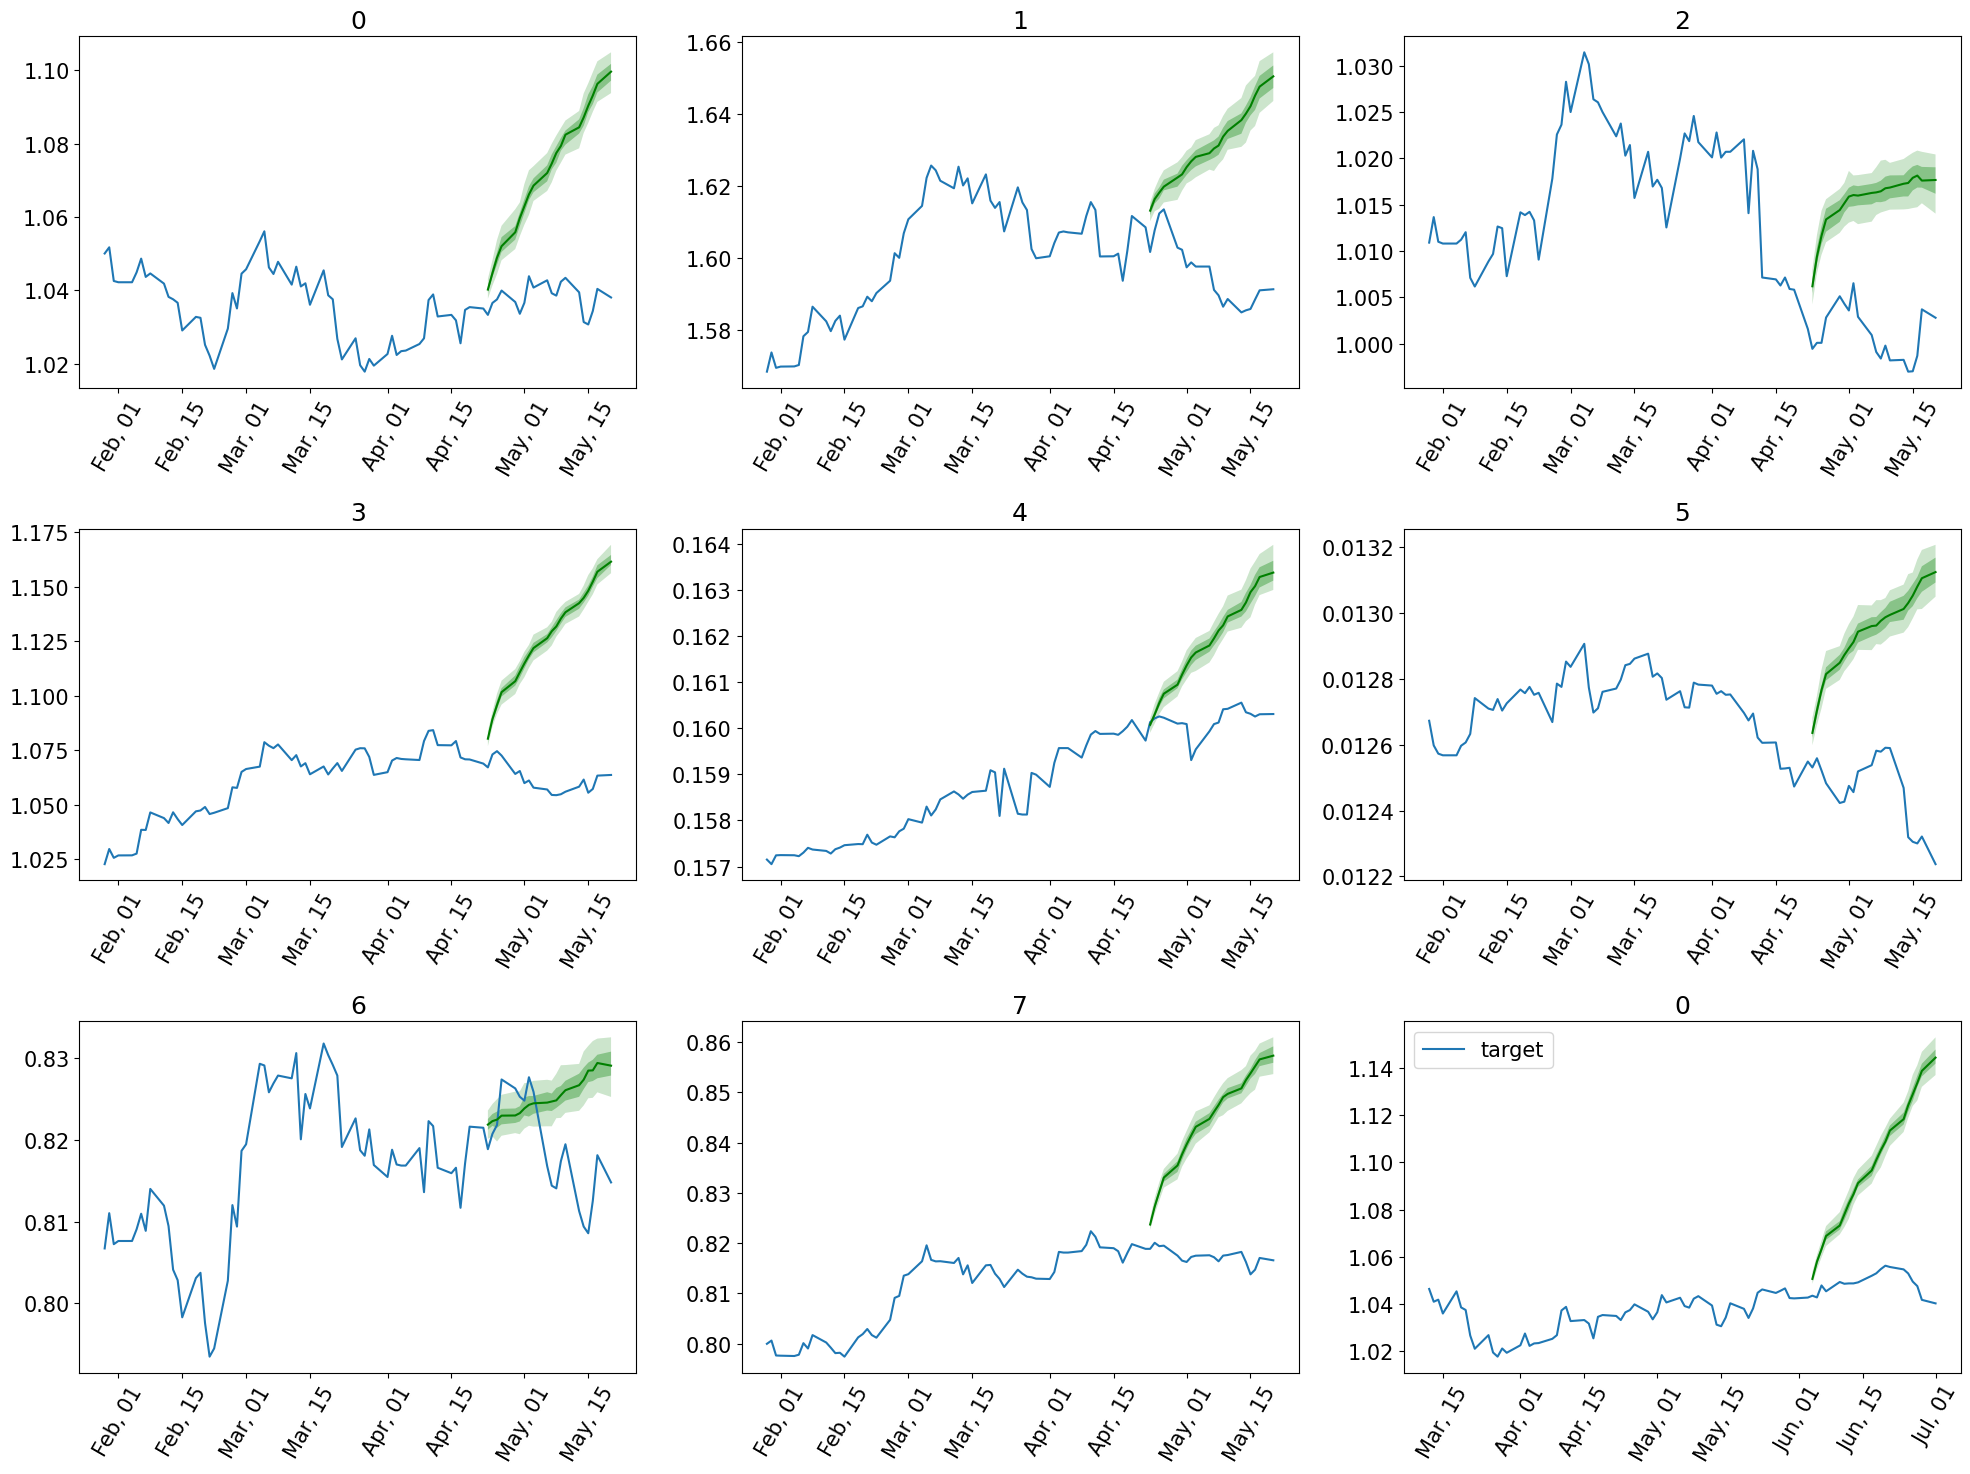

Running evaluation: 40it [00:00, 1317.36it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/multiprocessing/queues.py:389: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return _ForkingPickler.loads(res)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/multiprocessing/queues.py:389: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with fre

CRPS: 0.027099776164495368
WQL: 0.006864882506273475
MSE: 0.0011660529714907855
MAPE: 0.029561397852376103
RMSE: 0.034147517793988856
MASE: 4.42771636105819


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/evaluation/_base.py:289: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  metrics_per_ts = pd.DataFrame.from_records(rows)


In [18]:
path = "./lightning_logs/version_10/checkpoints/epoch=44-step=2250.ckpt"
forecasts_it, tss_it = _new_get_lag_llama_predictions(path, data_test, prediction_length=prediction_length, device=device,\
                                                    context_length=context_length, use_rope_scaling=True, num_samples=100)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

# Covid Deaths

# Traffic

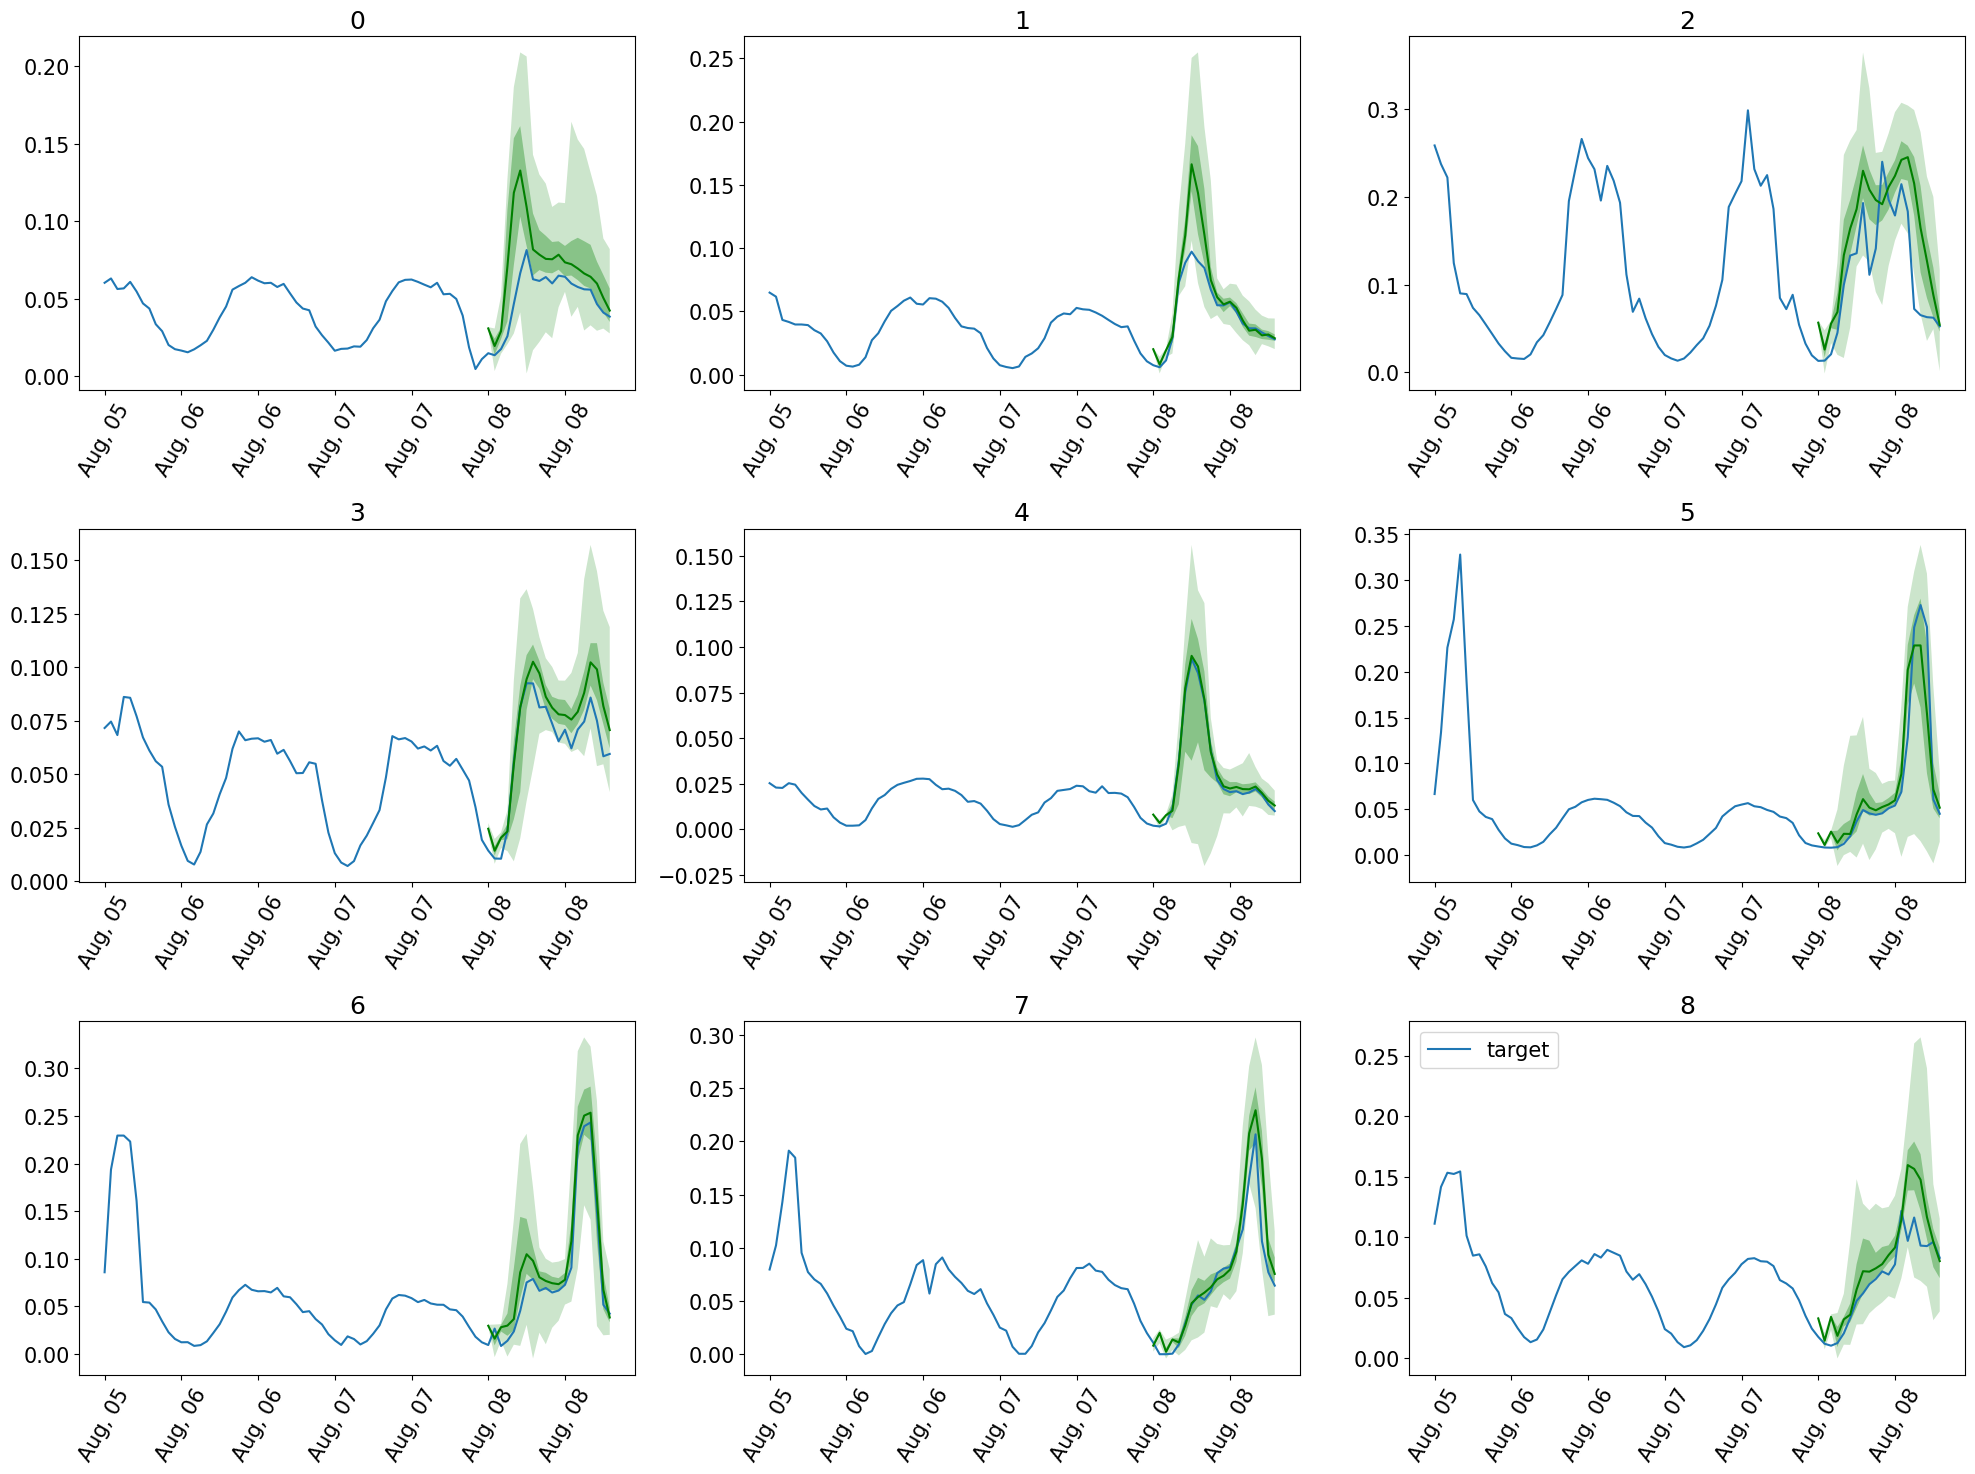

Running evaluation: 6034it [00:00, 155103.73it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to spe

CRPS: 0.18430349357397802
WQL: 0.1380656113586528
MSE: 0.0008289755517414386
MAPE: 0.7624190603612845
RMSE: 0.028791935533087013
MASE: 1.0556695383262193


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [22]:
path = "./lightning_logs/version_11/checkpoints/epoch=48-step=2450.ckpt"
forecasts_it, tss_it = _new_get_lag_llama_predictions(path, data_test, prediction_length=prediction_length, device=device,\
                                                    context_length=context_length, use_rope_scaling=True, num_samples=100)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])

# Weather

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


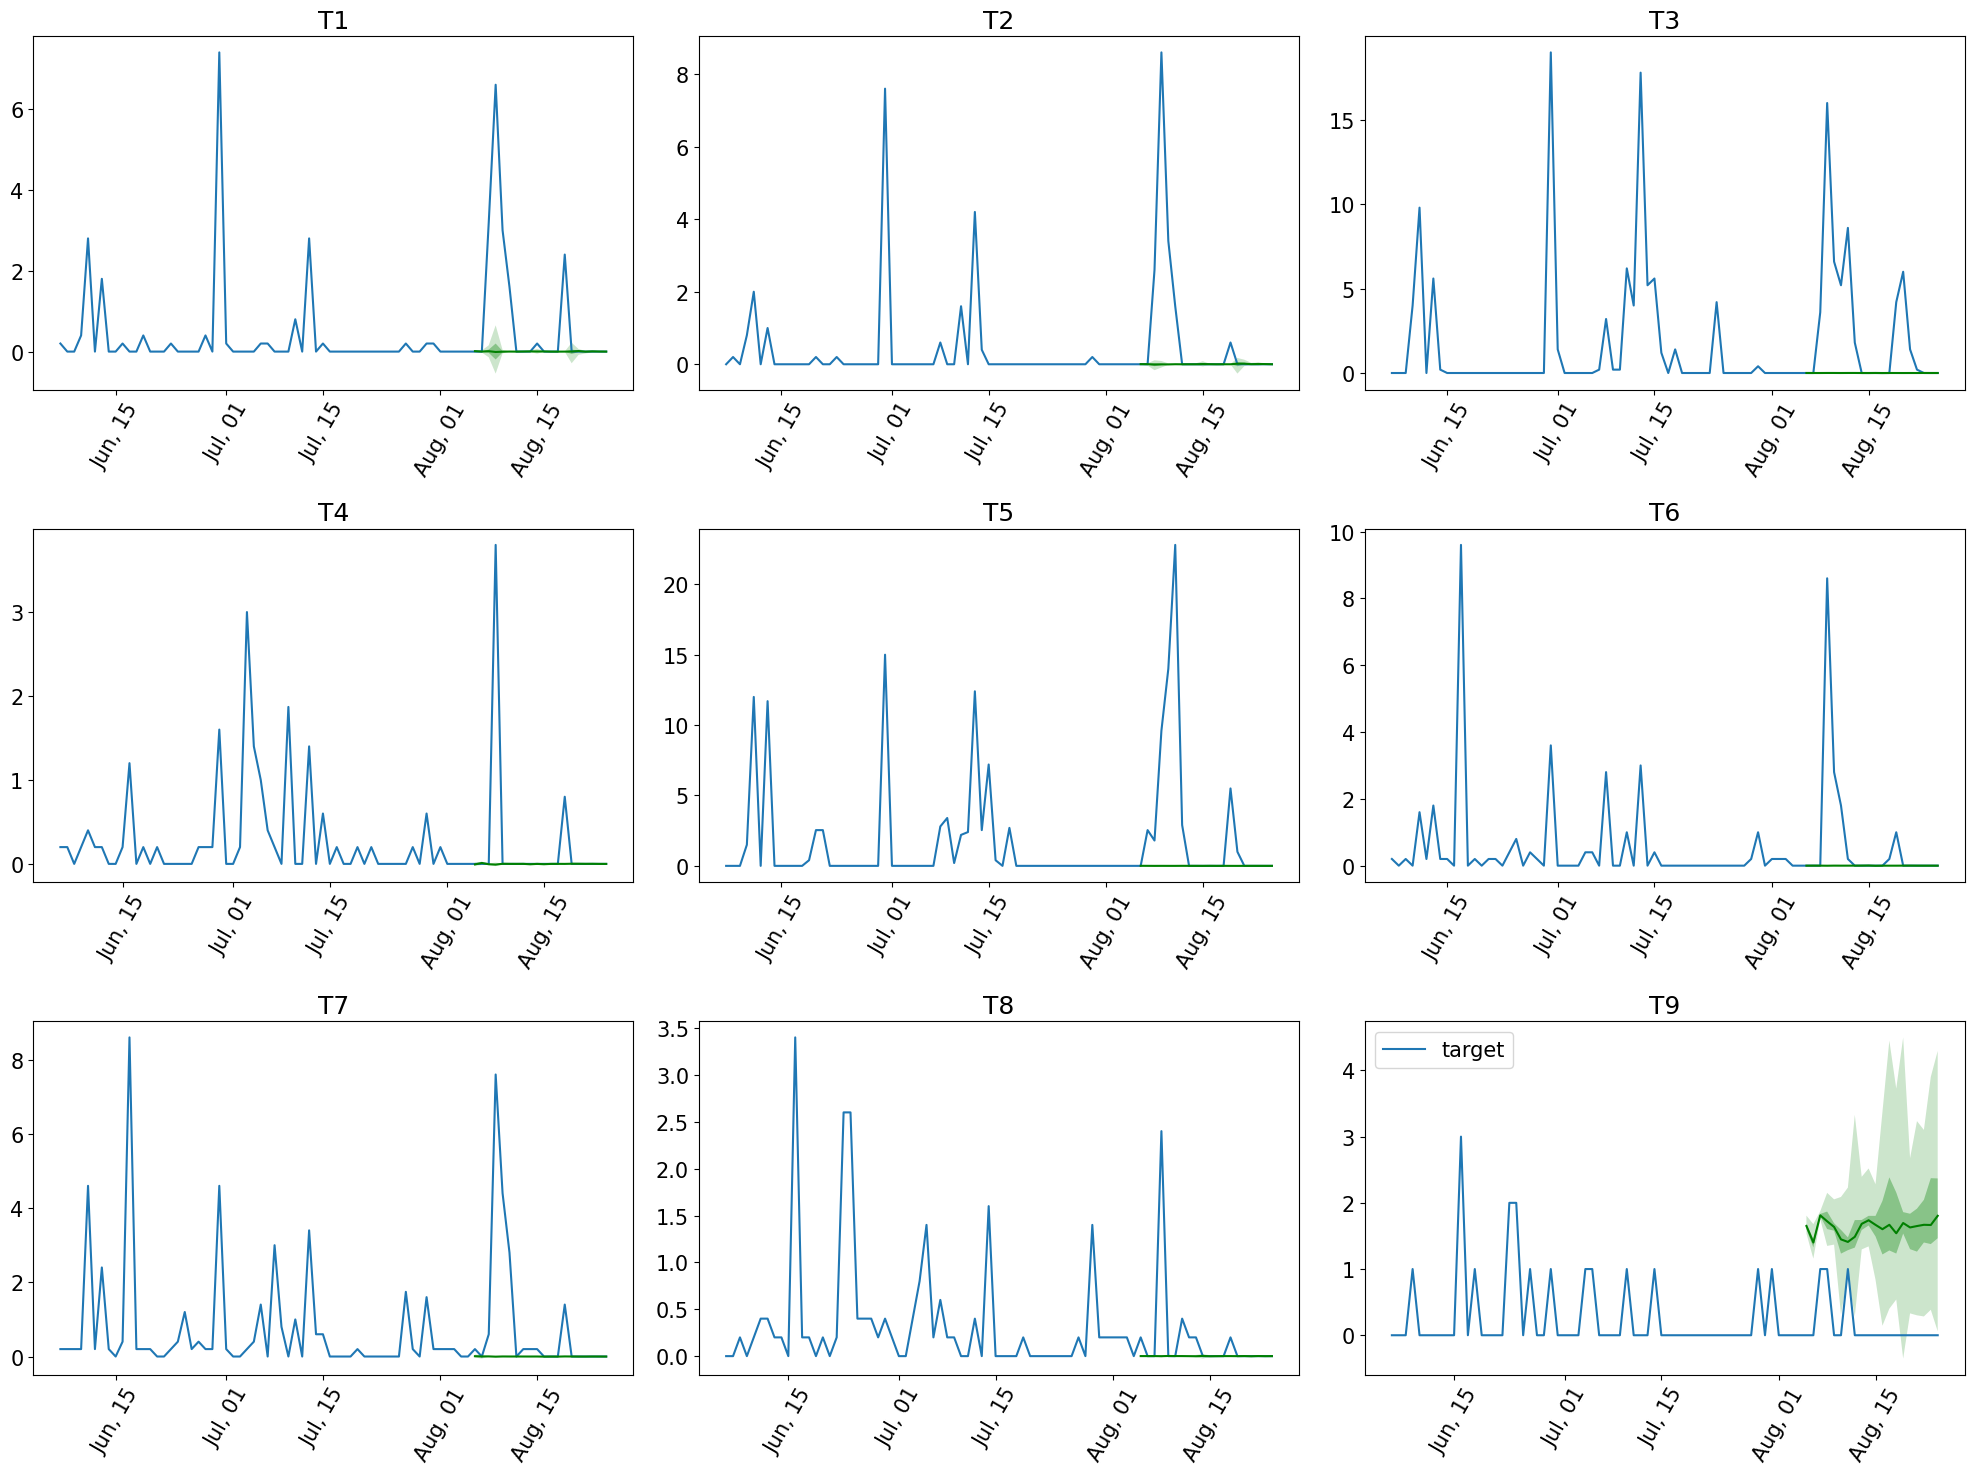

Running evaluation: 3010it [00:00, 85553.96it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to spee

CRPS: 0.16940506251421775
WQL: 0.1405783664548489
MSE: 23.728015450282072
MAPE: 0.7696568710907141
RMSE: 4.871141082978615
MASE: 1.0656103135701853
{'MSE': 23.728015450282072, 'abs_error': 138085.20399558742, 'abs_target_sum': 669118.3980471864, 'abs_target_mean': 11.114923555601104, 'seasonal_error': 2.6963091458379393, 'MASE': 1.0656103135701853, 'MAPE': 0.7696568710907141, 'sMAPE': 0.6769594339598156, 'MSIS': 13.382326301853952, 'num_masked_target_values': 0.0, 'QuantileLoss[0.1]': 55582.88762054664, 'Coverage[0.1]': 0.13616279069767442, 'QuantileLoss[0.2]': 90652.55562068216, 'Coverage[0.2]': 0.25802325581395347, 'QuantileLoss[0.3]': 114633.32989795873, 'Coverage[0.3]': 0.3680232558139535, 'QuantileLoss[0.4]': 129590.20344050322, 'Coverage[0.4]': 0.4953820598006644, 'QuantileLoss[0.5]': 138085.20445107808, 'Coverage[0.5]': 0.656046511627907, 'QuantileLoss[0.6]': 139372.55147196114, 'Coverage[0.6]': 0.7740033222591363, 'QuantileLoss[0.7]': 135743.15992084672, 'Coverage[0.7]': 0.8538

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [12]:
path = "./lightning_logs/version_9/checkpoints/epoch=34-step=1750.ckpt"
forecasts_it, tss_it = _new_get_lag_llama_predictions(path, data_test, prediction_length=prediction_length, device=device,\
                                                    context_length=context_length, use_rope_scaling=True, num_samples=100)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])
print(agg_metrics)

# Hospital

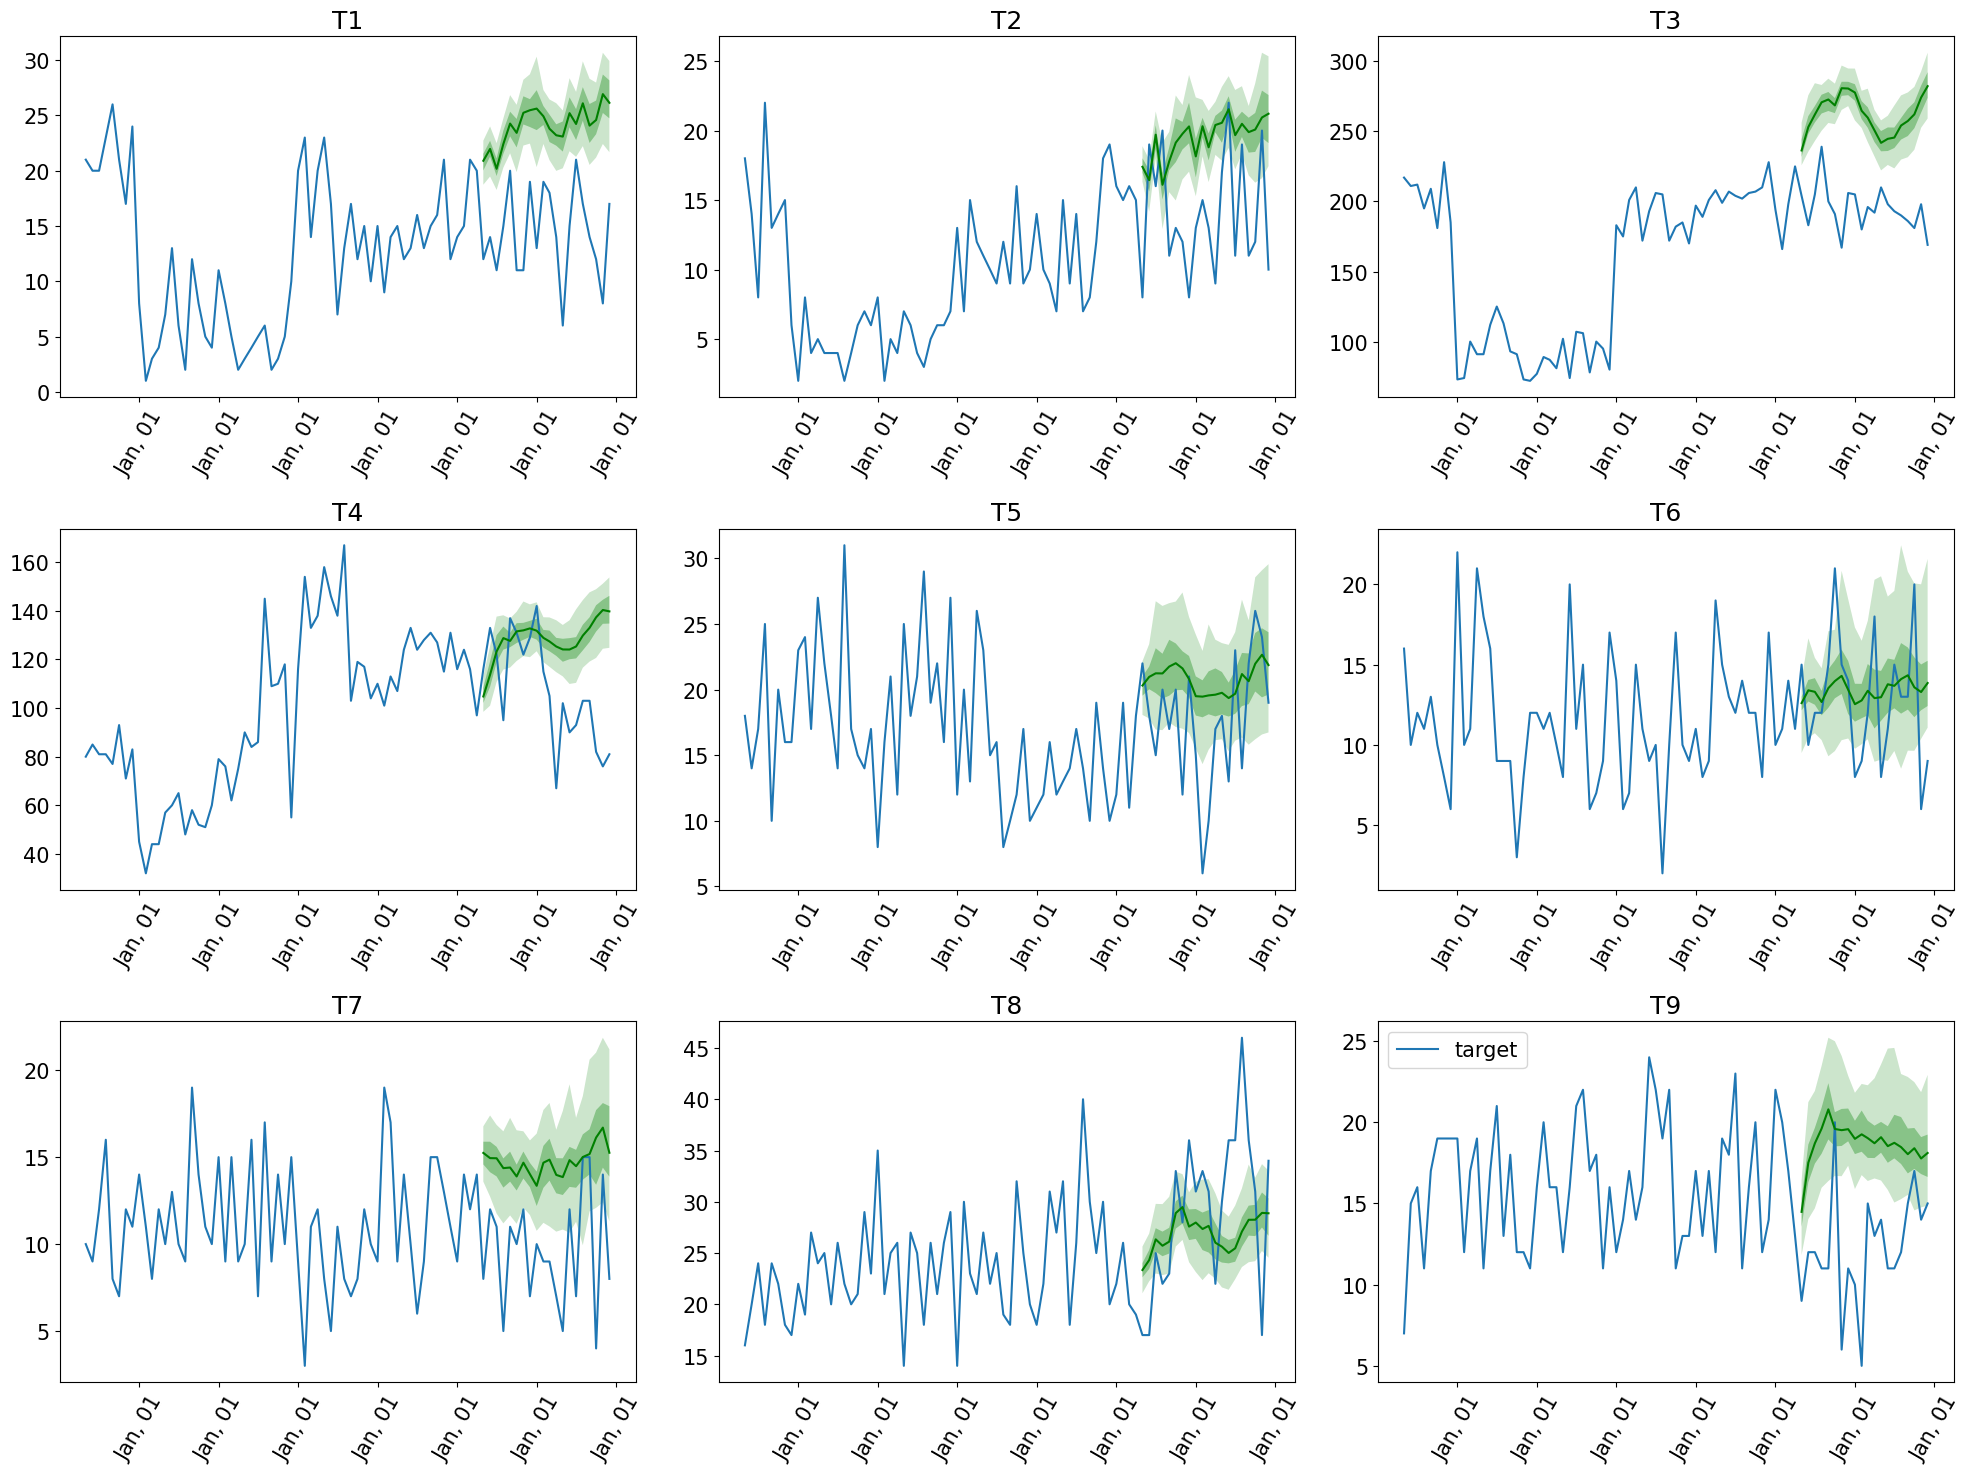

Running evaluation: 767it [00:00, 23994.27it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed

CRPS: 0.11819094272394848
WQL: 0.06491873171893134
MSE: 15201.936269017584
MAPE: 0.3746938334294683
RMSE: 123.29613241711024
MASE: 1.1590366642106043


In [26]:
path = "./lightning_logs/version_12/checkpoints/epoch=49-step=2500.ckpt"
forecasts_it, tss_it = _new_get_lag_llama_predictions(path, data_test, prediction_length=prediction_length, device=device,\
                                                    context_length=context_length, use_rope_scaling=True, num_samples=100)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])